In [74]:
import os
import pickle
import torch
import numpy as np
import scipy.sparse as sp
import dgl

from utils import select_source, compute_rank_error, compute_hit_ratio

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 訓練推薦系統

In [75]:
SEED = 42
EPOCHS = 100
TEST_RATIO = 0.3  # ratio for splitting the test set
DEVICE = "cpu"

In [76]:
with open(os.path.join("facebook", "combined-adj-sparsefeat.pkl"), "rb") as f:
    friendship_matrix, feature_matrix = pickle.load(f, encoding='latin1')

print(f"Friendship matrix shape : {friendship_matrix.shape}")
print(f"Feature matrix shape    : {feature_matrix.shape}")

src, dst = np.nonzero(friendship_matrix)
g = dgl.graph((src, dst))
g.ndata['feat'] = torch.tensor(feature_matrix.todense(), dtype=torch.float32)
g

Friendship matrix shape : (4039, 4039)
Feature matrix shape    : (4039, 1283)


Graph(num_nodes=4039, num_edges=176468,
      ndata_schemes={'feat': Scheme(shape=(1283,), dtype=torch.float32)}
      edata_schemes={})

In [77]:
def split_dataset(g):

    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    np.random.seed( SEED )
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set

    # get positive edges for test and train
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    # split the negative edges for training and testing
    np.random.seed( SEED )
    neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    # construct positive and negative graphs for training and testing
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

    # training graph
    train_g = dgl.remove_edges(g, eids[:test_size])
    train_g = dgl.add_self_loop(train_g)

    return {
        "train_pos_g": train_pos_g,
        "train_neg_g": train_neg_g,
        "test_pos_g":  test_pos_g,
        "test_neg_g":  test_neg_g,
        "train_g":     train_g
    }

In [78]:
from model import Pipeline

pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
ds = split_dataset(g)
train_losses = pipeline.train(ds)

100%|██████████| 100/100 [00:04<00:00, 21.11it/s]


AUC: 0.968032


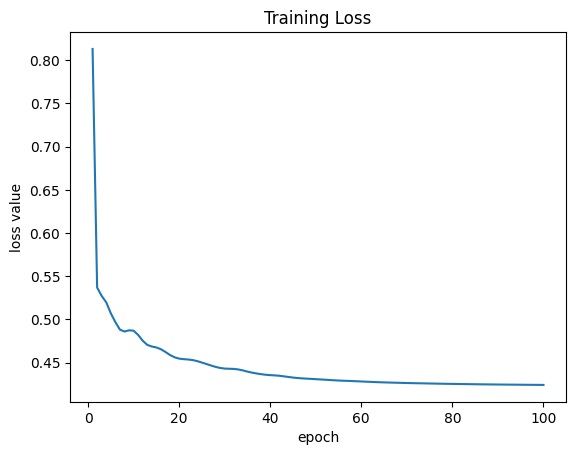

In [79]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.plot(range(1, EPOCHS+1), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

In [80]:
recommend_list = pipeline.recommend(g, 0)
print(recommend_list[:10])

[(3089, 9.62559700012207), (338, 8.091079711914062), (365, 4.881927013397217), (480, 4.796428203582764), (357, 4.67478084564209), (371, 4.534914016723633), (457, 4.387075424194336), (397, 4.284292221069336), (476, 4.279455184936523), (346, 4.187865257263184)]


### 方法二

In [81]:
MAX_CHANGES = 20
NUM_PAIRS = 20

RESTART_RATIO = 0.1
EPSILON = 1e-5
WALK_GRAPH = "weighted"

取樣一些成對的驗證資料

In [82]:
import random

pairs = []
start = 100
end = 200

random.seed(SEED)
targets = random.sample(range(0, friendship_matrix.shape[0]-1), NUM_PAIRS)

for tgt in targets:
    recommend_list = pipeline.recommend(g, tgt)
    src = select_source(recommend_list, start, end)
    pairs.append((src, tgt))

pairs[:5]

[(2331, 2619), (404, 456), (128, 102), (3111, 3037), (1640, 1126)]

In [83]:
def random_walk_with_restart(graph, start_point, restart_ratio, max_iter=100, tol=1e-6, device=torch.device("cpu")):
    # graph is already torch tensor
    init_vector = torch.zeros((graph.shape[0], 1), device=device)
    init_vector[start_point, 0] = 1
    p = init_vector.clone()
    
    for _ in range(max_iter):
        prev_p = p.clone()
        p = (1 - restart_ratio) * torch.mm(graph, p) + restart_ratio * init_vector
        if torch.norm(p - prev_p, p=1).item() < tol:
            break
    return p

def construct_normalized_graph(friends, features, epsilon=1e-4, walk_graph="weighted", device=torch.device("cpu")):
    if walk_graph == "adj":
        # normalize friends
        friends += epsilon * torch.eye(friends.shape[0], device=device)
        normalized_friends = friends / friends.sum(dim=1, keepdim=True)

    elif walk_graph == "weighted":
        # Compute feature inner product matrix
        feature_inner_product = torch.mm(features, features.t())
        
        # Replace the original adjacency matrix values with feature inner product values
        neighbors = (friends == 1)
        friends = friends.clone()  # Make a copy to avoid modifying the original tensor
        friends[neighbors] = feature_inner_product[neighbors]
        
        # Normalize the friends matrix
        friends += epsilon * torch.eye(friends.shape[0], device=device)
        normalized_friends = friends / friends.sum(dim=1, keepdim=True)

    else:
        raise ValueError("Error in reading parameter walk graph!!")

    return normalized_friends


def method_2(g, pair):
    user_id, tgt = pair
    g_copy = dgl.remove_self_loop(g.clone())
    device = torch.device(DEVICE)
    
    # get friends and feature metrix
    friends = g_copy.adj().to_dense()
    features = g_copy.ndata['feat'].to(device)
    # turn to float
    friends = friends.type(torch.FloatTensor).to(device)

    normalized_friends = construct_normalized_graph(friends, features, EPSILON, WALK_GRAPH, device)
    proximity = random_walk_with_restart(normalized_friends, tgt, RESTART_RATIO, device=device)

    proximity = proximity.reshape(-1).detach().cpu().numpy()

    top_friends = np.flip(np.argsort(proximity))[1:MAX_CHANGES+1]

    friends = friends.detach().cpu().numpy()
    features = features.detach().cpu().numpy()
    friends[top_friends, user_id] = 1
    friends[user_id, top_friends] = 1

    src, dst = np.nonzero(friends)
    g_change = dgl.graph((src, dst))
    g_change.ndata['feat'] = torch.tensor(features, dtype=torch.float32)

    return g_change

In [84]:
from tqdm.auto import tqdm

origin_ranks, new_ranks = [], []

for pair in tqdm(pairs):
    g_change = method_2(g, pair)

    origin_rank = pipeline.predict_rank(g, pair[0], pair[1])

    ds = split_dataset(g_change)
    new_pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
    train_losses = new_pipeline.train(ds)

    #new_rank = pipeline.predict_rank(g_change, pair[0], pair[1])
    new_rank = new_pipeline.predict_rank(g_change, pair[0], pair[1])

    origin_ranks.append(origin_rank)
    new_ranks.append(new_rank)

print( compute_rank_error(origin_ranks, new_ranks) )    

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:23<00:00,  7.18s/it]

{'average': -1.0, 'max': 1, 'min': -10}


In [85]:
print(origin_ranks)
print(new_ranks)

[127, 129, 164, 177, 103, 171, 125, 191, 183, 189, 169, 153, 128, 157, 175, 135, 100, 197, 120, 189]
[127, 129, 174, 179, 103, 172, 125, 195, 183, 188, 169, 153, 127, 157, 175, 134, 100, 198, 121, 193]
